# First run on the whole data
The model and training setting is adopted from the optimal model in the pilot study. The batch size is changed to 256, which is same as BERT, to reduce the training time.

```
ViT model: base
Constant learning rate: 1e-5
Optimizer: AdamW (betas=(0.9, 0.95)) 
Clips gradient norm
Data pre-processing: spectrum-wise standardization
Patch size: 16
Mask ratio: 0.75
Batch size: 256
Epochs: 100
```
Details please refer to `models_mae.py` and `main_pretrain.py`.


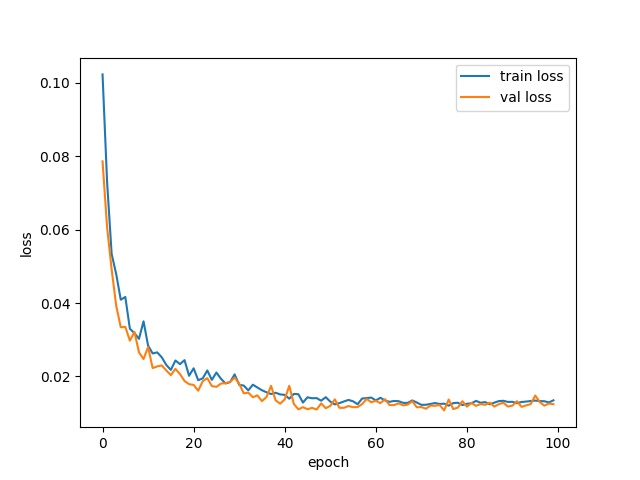

In [1]:
# display a png image
from IPython.display import Image
Image(filename='results/loss_1e-05_20231214.png')

In [2]:
import numpy as np
import torch
from util.datasets import get_dataloader, standardize
from util.evaluate import evaluate_base, evaluate_inraw, inverse_standardize
from models_mae import mae_vit_base_patch16
import matplotlib.pyplot as plt

In [3]:
# the base model
dataloader_raw = get_dataloader(annotations_file='data/info_20231214.csv', input_dir='data/spe',
                                batch_size=256, transform=None)
mse_base = evaluate_base(dataloader_raw['val'])

# the model with standardization
dataloader_std = get_dataloader(annotations_file='data/info_20231214.csv', input_dir='data/spe',
                                batch_size=256, transform=standardize)
model = mae_vit_base_patch16().to('cuda')
model.load_state_dict(torch.load('models/mae_vit_base_patch16_1e-05_20231214.pth'))
mse_std = evaluate_inraw(model, dataloader_raw['val'], dataloader_std['val'], inverse=inverse_standardize)

print(f'MSE: {round(mse_std, 1)}')
print(f'R2: {round(1 - mse_std / mse_base, 2)}')

MSE: 5400479.5
R2: 0.3


In [24]:
def eval(model, spe_arr):
    model.eval()
    with torch.no_grad():
        torch.manual_seed(24)
        spe = torch.from_numpy(spe_arr).to('cuda')
        return model(spe.unsqueeze(0).float())
    
def unpatchify(mask, pred, model):
    pred_un = model.unpatchify(pred)
    pred_un_arr = pred_un.squeeze(0).cpu().numpy()

    mask_arr = mask.squeeze(0).cpu().numpy()
    mask_un_arr = np.array([])
    for i in mask_arr:
        mask_un_arr = np.concatenate((mask_un_arr, np.repeat(i, 16)))
    mask_un_arr = mask_un_arr.astype(int)

    return pred_un_arr, mask_un_arr

def inverse_standardize(raws, pred_un):
    mean = raws.mean()
    std = raws.std()
    return pred_un * std + mean

def print_loss(spe_arr, pred_un_arr, mask_un_arr):
    # 0: unmasked, 1: masked
    # spe_arr: raw spectrum array
    # pred_un_arr: unpatchfied predicted spectrum array
    # mask_un_arr: unpatchfied mask array
    print(
            'loss of the masked part ({}): {:.3f}'.format(
                mask_un_arr.sum(),
                ((pred_un_arr - spe_arr)**2 * mask_un_arr).sum() / mask_un_arr.sum()
            )
    )
    print(
            'loss of the unmasked part ({}): {:.3f}'.format(
                (mask_un_arr==0).sum(),
                ((pred_un_arr - spe_arr)**2 * (mask_un_arr==0)).sum() / (mask_un_arr==0).sum()
            )
)

def plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=30):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    scale = .001
    channel = np.arange(1, len(spe_arr)+1)
    for ax in axes:
        if ax == axes[0]: # normal view
            ax.vlines(channel, ymin=0, ymax=mask_un_arr*(spe_arr.max()*scale), color='gray', alpha=0.3, label='masked')
            ax.plot(channel, spe_arr*scale, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr*scale, alpha=.6, label='pred')
            ax.set_xlim(-1, 2050)
            #ax.set_ylim(0, spe_arr.max()*scale)
            ax.set_ylabel('Counts (K)')
        else: # zoom in
            ax.vlines(channel, ymin=0, ymax=mask_un_arr*ymax, color='gray', alpha=0.3, label='masked')
            ax.plot(channel, spe_arr, alpha=.8, label='raw')
            ax.plot(channel, pred_un_arr, alpha=.6, label='pred')
            
            ax.set_ylim(0, ymax)
            ax.set_ylabel('Counts')
            ax.set_xlim(-1, 2050)

        ax.set_xlabel('Channel')
        ax.legend()
    plt.show()

In [12]:
# read data
spe_arr = dataloader_std['val'].dataset[60]

# inference
loss, pred, mask = eval(model, spe_arr)
pred_un_arr, mask_un_arr = unpatchify(mask, pred, model)

loss of the masked part (1536): 0.007
loss of the unmasked part (512): 0.006


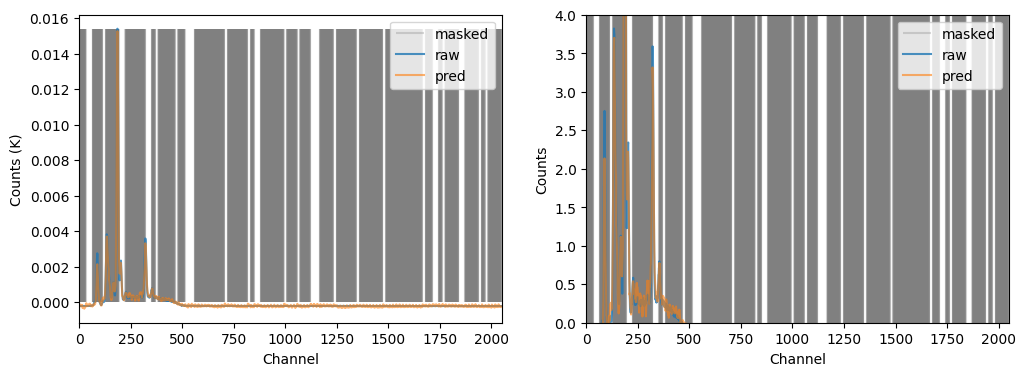

In [16]:
# std space
print_loss(spe_arr, pred_un_arr, mask_un_arr)
plot_spectrum(spe_arr, pred_un_arr, mask_un_arr, ymax=4)

loss of the masked part (1536): 15908.948
loss of the unmasked part (512): 13596.020


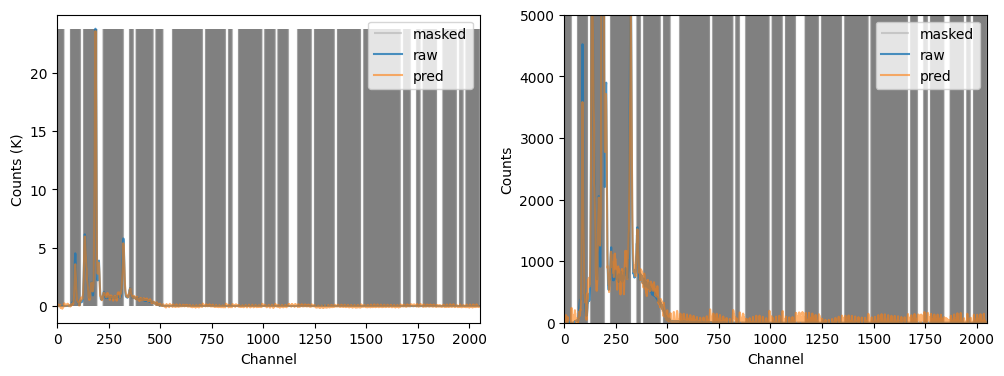

In [26]:
# raw space
spe_raw_arr = dataloader_raw['val'].dataset[60]
print_loss(spe_raw_arr, inverse_standardize(spe_raw_arr, pred_un_arr), mask_un_arr)
plot_spectrum(spe_raw_arr, inverse_standardize(spe_raw_arr, pred_un_arr), mask_un_arr, ymax=5000)

At the first glance, it's not bad. The training is converging, but a bit kinky. The learning rate needs to be tuned, perhaps with variable learning rates. The MSE loss in the validation set is ~7 times larger than the pilot study. It may indicate the complex of the whole dataset or the necessity of hyperparameter tuning. Furthermore, if I visualize a spectrum from the validation set, the prediction is not that bad. This may point out the validation set has some very different spectra, so there are some extremily large errors.

The training time for one epoch is increased from ~1.4s to 37s, even after the increase of batch size.

BTW, this data split include the case study cores, so I'll need to exclude them in the next round.